<a href="https://colab.research.google.com/github/anqixxx/machine-learning/blob/main/%20license%20plate%20identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import string
import random
import re

from random import randint
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw
from matplotlib import pyplot as plt
import matplotlib.image as mpimg


In [19]:
# Run this command only once:

# makes the output folder /content/pictures/
!mkdir pictures

mkdir: cannot create directory ‘pictures’: File exists


In [20]:
# Run this command only once

# Downloads the license plate template to /content/blank_plate.png
!gdown --id 1Q_FsX2z6DaDCLM91qGZzwvctaW9bN60v

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Q_FsX2z6DaDCLM91qGZzwvctaW9bN60v
To: /content/blank_plate.png
100% 144k/144k [00:00<00:00, 92.2MB/s]


# Data Engine


## Data Generation


In [21]:
path = "/content/"

NUMBER_OF_PLATES = 30
database = []

for i in range(0, NUMBER_OF_PLATES):

    # Pick two random letters
    plate_alpha = "" # Initializes empty string
    for _ in range(0, 2):
        plate_alpha += (random.choice(string.ascii_uppercase))

    # Pick two random numbers
    num = randint(0, 99)
    plate_num = "{:02d}".format(num) # What does this line mean?

    # Write plate to image
    blank_plate = cv2.imread(path+'blank_plate.png')

    # Convert into a PIL image (this is so we can use the monospaced fonts)
    blank_plate_pil = Image.fromarray(blank_plate)

    # Get a drawing context
    draw = ImageDraw.Draw(blank_plate_pil)
    monospace = ImageFont.truetype(font="/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf", 
                                   size=165)
    draw.text(xy=(48, 75),
              text=plate_alpha + " " + plate_num, 
              fill=(255,0,0), font=monospace)

    # Convert back to OpenCV image and save
    blank_plate = np.array(blank_plate_pil)

    # Write license plate to file
    cv2.imwrite(os.path.join(path + "pictures/", 
                             "plate_{}{}.png".format(plate_alpha, plate_num)),
                             blank_plate) 
    
    # Save data used
    database = database + list(plate_alpha) + list(map(str, str(num)))

# print(database)

['Q', 'Z', '7', '6', 'H', 'X', '8', '7', 'N', 'E', '1', '7', 'L', 'O', '6', '6', 'P', 'R', '1', '2', 'X', 'P', '1', '0', 'F', 'W', '1', '1', 'Y', 'A', '1', 'B', 'X', '4', '3', 'Z', 'N', '7', '4', 'Z', 'B', '1', '1', 'W', 'L', '6', '3', 'Y', 'E', '3', 'Q', 'M', '7', 'A', 'O', '5', '5', 'A', 'M', '6', '3', 'U', 'A', '6', '0', 'J', 'I', '5', '5', 'F', 'C', '6', '3', 'K', 'S', '4', '4', 'C', 'Q', '1', 'C', 'E', '1', '0', 'W', 'Y', '9', '8', 'I', 'M', '8', '0', 'O', 'L', '1', '5', 'O', 'M', '7', '9', 'L', 'O', '2', '0', 'S', 'D', '6', '2', 'T', 'P', '6', '1', 'C', 'A', '3', '5']


## One-hot Vector Encoding

In [38]:
# Function that converts row number 
# (i.e. the changed label from the Y dataset)
# into a one_hot vector array
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T # C is the amount of labels we have (36)
    return Y # Y must be in number format corresponding to matrix rows

def one_hot_label(character):
  # List to allow maping from character to row numbers
  one_hot_map = "ABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890"
  return one_hot_map.find(character)

def one_hot_rev(index):
  # List to allow maping from character to row numbers
  one_hot_map = "ABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890"
  return one_hot_map[index]

A


## Load image database

In [23]:
# Access each image in the database
PATH = "/content/pictures"

In [24]:
def files_in_folder(folder_path):
  '''
  Returns a list of strings where each entry is a file in the folder_path.
  
  Parameters
  ----------
  
  folder_path : str
     A string to folder for which the file listing is returned.
     
  '''
  files_A = !ls "{folder_path}"
  # The files when listed from Google Drive have a particular format. They are
  # grouped in sets of 4 and have spaces and tabs as delimiters.
  
  # Split the string listing sets of 4 files by tab and space and remove any 
  # empty splits.
  files_B = [list(filter(None, re.split('\t|\s', files))) for files in files_A]
  
  # Concatenate all splits into a single sorted list
  files_C = []
  for element in files_B:
    files_C = files_C + element
  files_C.sort()
  
  return files_C

raw_images = files_in_folder(PATH)

In [25]:
# # Example code for how to access images as arrays and as images
# im = Image.open(PATH+'/plate_NV69.png')  # or PATH + element, for element in raw_images

# # print(img) # array
# imgplot = plt.imshow(im) # image
# print(raw_images) # array of image names 


## Image Processing


In [26]:
# For each image in the data set, split it up into 4 images all centering on one image
# For valid inputs into the CNN, the image sizes must all be the same

# Then split it up, then label (would we be able to do this using the image name?)
# Can do this as two nested for loops, first iterates over all photos
# The second splits each photo into four images and assigns a label based on the file name
# Based on the one_hot list, create a tuple with the image and the label through
# How the label maps to the vector
NUMBER_OF_LABELS = 36
# Take raw images

# (x,y) = 48, 75
# can assume its 5 elements, ignore middle
# split into 5, then take first two and last two
  # image 1 is 48-148
  # image 2 is 149 - 249
  # image 3  351-451
  # image 4 is 452 to 552
  # all images are 75 to 223 in y
  # therefore overall dimensions are 100 by 148

all_dataset = [] # array or list of tupples

for element in raw_images:
  # print(element)
  im = Image.open(PATH+'/'+element)

  # section off first image 
  label_1 = one_hot_label(element[6])
  image_1 = im.crop((48, 75, 148, 223))
  # imgplot = plt.imshow(image_1) # image
  temp_tuple = [np.array(image_1), label_1]
  all_dataset.append(tuple(temp_tuple))

  label_2 = one_hot_label(element[7])
  image_2 = im.crop((149, 75, 249, 223))
  # imgplot = plt.imshow(image_2) # image
  temp_tuple = [np.array(image_2), label_2]
  all_dataset.append(tuple(temp_tuple))

  label_3 = one_hot_label(element[8])
  image_3 = im.crop((351, 75, 451, 223))
  # imgplot = plt.imshow(image_3) # image
  temp_tuple = [np.array(image_3), label_3]
  all_dataset.append(tuple(temp_tuple))

  label_4 = one_hot_label(element[9])
  image_4 = im.crop((452, 75, 552, 223))
  # imgplot = plt.imshow(image_4) # image
  temp_tuple = [np.array(image_4), label_4]
  all_dataset.append(tuple(temp_tuple))

# print(all_dataset)


plate_AH48.png
plate_AK93.png
plate_AM63.png
plate_AO55.png
plate_AO63.png
plate_BP93.png
plate_BX43.png
plate_BX69.png
plate_CA14.png
plate_CA35.png
plate_CD54.png
plate_CE10.png
plate_CO03.png
plate_CQ01.png
plate_CZ19.png
plate_DY47.png
plate_EB99.png
plate_EM77.png
plate_FC63.png
plate_FW11.png
plate_GK08.png
plate_GN73.png
plate_HI67.png
plate_HX87.png
plate_IM80.png
plate_JA86.png
plate_JI55.png
plate_JR34.png
plate_KC95.png
plate_KJ75.png
plate_KS44.png
plate_KW20.png
plate_LG52.png
plate_LJ74.png
plate_LN39.png
plate_LO20.png
plate_LO66.png
plate_LQ57.png
plate_LR35.png
plate_MF36.png
plate_MH45.png
plate_ML55.png
plate_NE17.png
plate_NR82.png
plate_NY16.png
plate_OH84.png
plate_OL15.png
plate_OM79.png
plate_PR12.png
plate_PV70.png
plate_QB22.png
plate_QG22.png
plate_QM07.png
plate_QO56.png
plate_QZ76.png
plate_RI94.png
plate_RY80.png
plate_SD62.png
plate_SI65.png
plate_SN74.png
plate_SS58.png
plate_SW27.png
plate_TP61.png
plate_TS77.png
plate_TV10.png
plate_TZ68.png
plate_UA60

In [27]:
# Shuffle the dataset
# np.random.shuffle(all_dataset)

In [28]:
# Genereate X and Y datasets
X_dataset_orig = np.array([data[0] for data in all_dataset[:]])
Y_dataset_orig = np.array([[data[1]] for data in all_dataset])
# X is examples, Y is labels for the examples

In [29]:
# Normalize X (images) dataset
X_dataset = X_dataset_orig/255.

# Convert Y dataset to one-hot encoding
Y_dataset = convert_to_one_hot(Y_dataset_orig, NUMBER_OF_LABELS).T
print(Y_dataset)
print(X_dataset)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[[0.85098039 0.85490196 0.87058824]
   [0.84705882 0.85098039 0.86666667]
   [0.85490196 0.85882353 0.8745098 ]
   ...
   [0.89411765 0.89411765 0.90196078]
   [0.90196078 0.90196078 0.91372549]
   [0.8745098  0.87058824 0.88235294]]

  [[0.84705882 0.85098039 0.86666667]
   [0.85098039 0.85490196 0.87058824]
   [0.85882353 0.85882353 0.8745098 ]
   ...
   [0.87058824 0.8745098  0.89019608]
   [0.87058824 0.8745098  0.89019608]
   [0.85882353 0.8627451  0.87843137]]

  [[0.85098039 0.85490196 0.87058824]
   [0.84705882 0.85098039 0.86666667]
   [0.85882353 0.8627451  0.87843137]
   ...
   [0.8745098  0.87843137 0.89411765]
   [0.87058824 0.8745098  0.89019608]
   [0.85882353 0.8627451  0.87843137]]

  ...

  [[0.83921569 0.84313725 0.85882353]
   [0.83921569 0.84313725 0.85882353]
   [0.84313725 0.84705882 0.8627451 ]
   ...
   [0

# Neural Network Classifier Design

## Design Convolutional Neural Net

## Train CNN

In [30]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

## Model Definition

In [31]:
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=(148, 100, 3)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(512, activation='relu'))
conv_model.add(layers.Dense(36, activation='softmax')) # Amount of labels, ie. things we are trying to classify

In [32]:
conv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 98, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 33, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 10, 128)      0

In [33]:
LEARNING_RATE = 1e-4 # How fast we are changing the gradient
conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(lr=LEARNING_RATE),
                   metrics=['acc'])
# Metrics is like eval critera, in this case acc is accuracy, we want to track this

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [34]:
VALIDATION_SPLIT = .2 # used to validate dataset

history_conv = conv_model.fit(X_dataset, Y_dataset, 
                              validation_split=VALIDATION_SPLIT, 
                              epochs=80, # Epoch is one full iteration of the dataset
                              batch_size=16) 
                              # Every time you do a training set, how many examples from the data you take

Epoch 1/80
18/18 [==============================] - 13s 33ms/step - loss: 3.4963 - acc: 0.1181 - val_loss: 3.3938 - val_acc: 0.1250
Epoch 2/80
18/18 [==============================] - 0s 14ms/step - loss: 3.2442 - acc: 0.2014 - val_loss: 3.1065 - val_acc: 0.1389
Epoch 3/80
18/18 [==============================] - 0s 14ms/step - loss: 2.7451 - acc: 0.3507 - val_loss: 2.5031 - val_acc: 0.4722
Epoch 4/80
18/18 [==============================] - 0s 16ms/step - loss: 1.9798 - acc: 0.5451 - val_loss: 1.7488 - val_acc: 0.5972
Epoch 5/80
18/18 [==============================] - 0s 14ms/step - loss: 1.2038 - acc: 0.7188 - val_loss: 1.0074 - val_acc: 0.7500
Epoch 6/80
18/18 [==============================] - 0s 14ms/step - loss: 0.7396 - acc: 0.8021 - val_loss: 0.5070 - val_acc: 0.8611
Epoch 7/80
18/18 [==============================] - 0s 13ms/step - loss: 0.4910 - acc: 0.8681 - val_loss: 0.2198 - val_acc: 0.9722
Epoch 8/80
18/18 [==============================] - 0s 14ms/step - loss: 0.3494 - 

## Loss and Fit

Model Loss

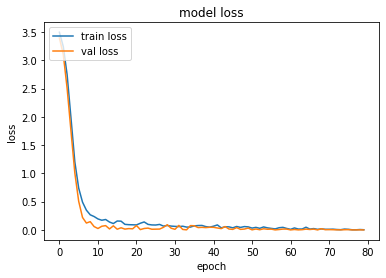

In [35]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

## Plot the confuson matrix


Model Accuracy

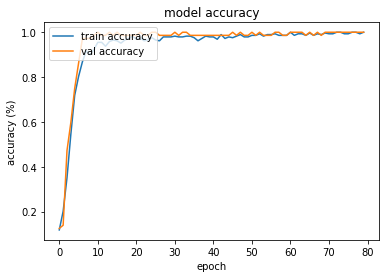

In [36]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

# Test Model


In [48]:
from ipywidgets import interact
import ipywidgets as ipywidgets

[1.03847420e-09 1.05353892e-09 2.71302024e-13 1.38325237e-11
 9.33765652e-12 8.94218657e-11 1.36120848e-09 1.77810155e-10
 9.44258893e-09 1.04980646e-08 3.13747778e-10 3.17172070e-13
 8.62395919e-11 3.38401562e-13 5.51208454e-11 2.97996675e-12
 3.32296204e-11 1.08237925e-08 8.41904111e-08 1.19929511e-10
 1.09890042e-15 6.63112230e-12 4.08118456e-10 8.14157275e-09
 5.92825455e-10 1.52105095e-09 7.71413211e-11 1.27331274e-08
 9.99995470e-01 2.49565035e-09 2.71846599e-08 1.68433734e-09
 3.30092981e-10 3.78350319e-06 7.39262607e-09 6.12862038e-07]
0.99999547
3


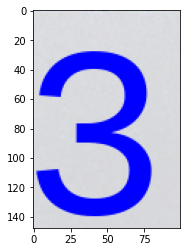

In [63]:
# Display images in the training data set. 
def displayImage(index):
  img = X_dataset[index]
  
  img_aug = np.expand_dims(img, axis=0)
  # print(conv_model.predict(img_aug)[0])
  y_predict = conv_model.predict(img_aug)[0]
  
  plt.imshow(img) 
  # print( np.max(y_predict))

  print(one_hot_rev(int(y_predict. argmax())))

displayImage(7)

In [37]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored